<a href="https://colab.research.google.com/github/Harsha-Amarasinghe/AI-Consistency-improvement-final-year-project/blob/main/FYP_Consistency_Improvement_NEW_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Required Libraries

In [ ]:
 !pip install -qU \
    datasets==2.14.5 \
    groq==0.8.0 \
    "semantic-router[local]==0.0.45" \
    pinecone-client==4.1.0 \
    sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.5/215.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.5/178.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.8/328.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

# Data Preparation

Load Dataset

In [ ]:
from datasets import load_dataset

data = load_dataset(
    "jamescalam/ai-arxiv2-semantic-chunks",
    split="train[:10000]"
)
data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'title', 'content', 'prechunk_id', 'postchunk_id', 'arxiv_id', 'references'],
    num_rows: 10000
})

In [ ]:
data[0]

{'id': '2401.04088#0',
 'title': 'Mixtral of Experts',
 'content': '4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a # Mixtral of Experts Albert Q. Jiang, Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume Lample, LÃ©lio Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, Szymon Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El Sayed Abstract We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts

Data Transformation & Remove Unnecessary Columns:





In [ ]:
data = data.map(lambda x: {
    "id": x["id"],
    "metadata": {
        "title": x["title"],
        "content": x["content"],
    }
})
# drop uneeded columns
data = data.remove_columns([
    "title", "content", "prechunk_id",
    "postchunk_id", "arxiv_id", "references"
])
data

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'metadata'],
    num_rows: 10000
})

Initialize HuggingFace Encoder:



In [ ]:
from semantic_router.encoders import HuggingFaceEncoder
encoder = HuggingFaceEncoder(name="dwzhu/e5-base-4k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/225M [00:00<?, ?B/s]

Configure Pinecone Client:



In [ ]:
import os
import getpass
from pinecone import Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.getenv("PINECONE_API_KEY") or getpass.getpass("Enter your Pinecone API key: ")

# configure client
pc = Pinecone(api_key=api_key)

Enter your Pinecone API key: ··········


In [ ]:
from pinecone import ServerlessSpec

spec = ServerlessSpec(
    cloud="aws", region="us-east-1"
)

Create Pinecone Index & connect:



In [ ]:
import time

index_name = "groq-llama-3-rag"
existing_indexes = [
    index_info["name"] for index_info in pc.list_indexes()
]

# check if index already exists (it shouldn't if this is first time)
if index_name not in existing_indexes:
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=dims,
        metric='cosine',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 10000}},
 'total_vector_count': 10000}

Batch Processing and Upsert Data:



In [ ]:
from tqdm.auto import tqdm

batch_size = 128  # how many embeddings we create and insert at once

for i in tqdm(range(0, len(data), batch_size)):
    # find end of batch
    i_end = min(len(data), i+batch_size)
    # create batch
    batch = data[i:i_end]
    # create embeddings
    chunks = [f'{x["title"]}: {x["content"]}' for x in batch["metadata"]]
    embeds = encoder(chunks)
    assert len(embeds) == (i_end-i)
    to_upsert = list(zip(batch["id"], embeds, batch["metadata"]))
    # upsert to Pinecone
    index.upsert(vectors=to_upsert)

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
batch["metadata"]

[{'content': '4 . So the answer is 9Ï 4 . Are there variables in the solution? the form of "1. variable is defined as...". If so, please list the definition of variable in The underlined parts are the type of question, the question itself and the steps in its solution, respectively. The output from the LLM is: Yes. There are variables in the solution. x + yi, where xxx and yyy are real numbers. x + yi 1. zzz is defined as a complex number of the form x + yi',
  'title': 'SelfCheck: Using LLMs to Zero-Shot Check Their Own Step-by-Step Reasoning'},
 {'content': 'The bold part is then saved to form a part of the input in the regeneration stage. Target extraction To get a brief and clear target of the current step, the input to the LLM is: The following is a part of the solution to the problem: Let S be the set of complex numbers z such that the real part of 1 6 . This set forms a curve. Find the area of the 12 region inside the curve. (Step 0) Let z = x + yi be a complex number, where x a

Initialize Groq Client:



In [ ]:
from groq import Groq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY") or getpass.getpass("Enter your Groq API key: ")

groq_client = Groq(api_key=os.environ["GROQ_API_KEY"])

Enter your Groq API key: ··········


Querying Documents:



In [ ]:
def get_docs(query: str, top_k: int) -> list[str]:
    xq = encoder([query])
    res = index.query(vector=xq, top_k=top_k, include_metadata=True)
    docs = [x["metadata"]['content'] for x in res["matches"]]
    return docs

# Factual Consistency

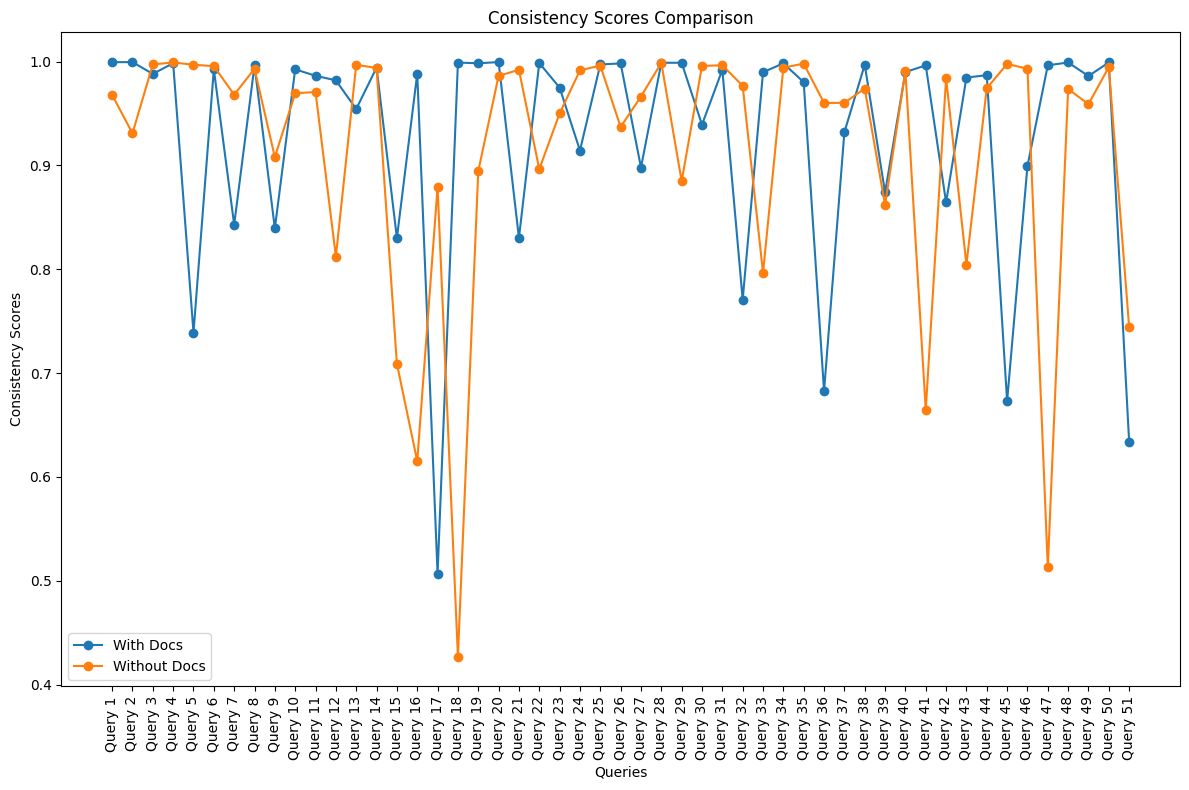

<Figure size 640x480 with 0 Axes>

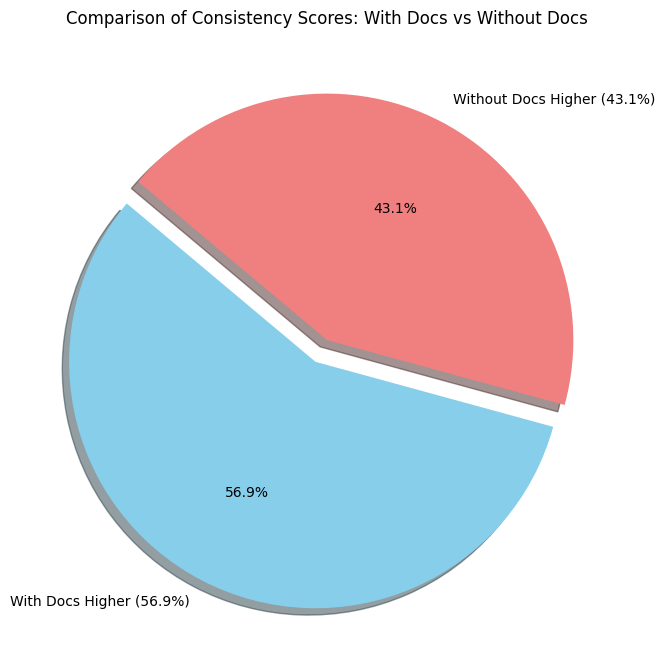

In [ ]:
import matplotlib.pyplot as plt
from transformers import pipeline
import torch
import pandas as pd

def generate(query: str, docs: list[str]):
    system_message = (
        "You are a helpful assistant that answers questions about AI using the "
        "context provided below.\n\n"
        "CONTEXT:\n"
        "\n---\n".join(docs)
    )
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": query}
    ]
    chat_response = groq_client.chat.completions.create(
        model="llama3-70b-8192",
        messages=messages
    )
    return chat_response.choices[0].message.content

def generateQueryOnly(query: str):
    system_message = (
        "You are a helpful assistant that answers questions about AI using the "
        "context provided below.\n\n"
        "CONTEXT:\n"
        "\n---\n"
    )
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": query}
    ]
    chat_response = groq_client.chat.completions.create(
        model="llama3-70b-8192",
        messages=messages,
    )
    return chat_response.choices[0].message.content

def calculate_consistency_score(query: str, response: str) -> float:
    model_name = "ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli"

    # Check if GPU is available and set the device
    device = 0 if torch.cuda.is_available() else -1

    # Initialize the pipeline with device configuration
    fact_checker = pipeline("text-classification", model=model_name, device=device, truncation=True)

    # Single question and answer
    input_text = f"{query} {response}"

    # Evaluate the answer
    result = fact_checker(input_text)[0]['score']

    return result

# Queries
queries = [
    "can you tell me about the Llama LLMs?",
    "can Generative AI models be influenced by emotional stimuli?",
    "Tell me about the Mixtral of experts paper?",
    "what is LLaVa-13b?",
    "Give details about dramatic improvement of the selective SSM when the state size ð is increased?",
    "What are the main differences between supervised and unsupervised learning?",
    "How does reinforcement learning work?",
    "What is the significance of transfer learning in AI?",
    "How do convolutional neural networks (CNNs) function?",
    "What are the key challenges in natural language processing (NLP)?",
    "Can you explain the concept of overfitting in machine learning?",
    "What are generative adversarial networks (GANs) and how do they work?",
    "How do transformers differ from traditional neural networks?",
    "What are the ethical considerations in AI development?",
    "How is explainable AI important in modern applications?",
    "What is the role of big data in machine learning?",
    "How do you evaluate the performance of a machine learning model?",
    "What is the difference between AI, machine learning, and deep learning?",
    "How do recurrent neural networks (RNNs) handle sequential data?",
    "What are the applications of AI in healthcare?",
    "How does AI impact the job market?",
    "What are the limitations of current AI technologies?",
    "How is AI used in autonomous vehicles?",
    "What are the future trends in AI research?",
    "How do you handle missing data in machine learning?",
    "How can attention mechanisms improve NLP models?",
    "What is the BERT model and how does it work?",
    "How are embeddings used in NLP?",
    "Can you explain the concept of zero-shot learning?",
    "What are the common datasets used for training NLP models?",
    "How does sentiment analysis work in NLP?",
    "What are the differences between sequence-to-sequence models and traditional NLP models?",
    "How do you preprocess text data for machine learning?",
    "What is the role of tokenization in NLP?",
    "How can you fine-tune pre-trained language models?",
    "What is the significance of word vectors in NLP?",
    "How does the transformer architecture work?",
    "What are the challenges in training large language models?",
    "Can you explain the concept of masked language modeling?",
    "How is unsupervised learning applied in NLP?",
    "What are the advantages of using pre-trained models in NLP?",
    "How do you evaluate NLP models?",
    "What are the key differences between text classification and text generation tasks?",
    "How does machine translation work?",
    "What are the ethical considerations in using NLP models?",
    "How can NLP models be used for text summarization?",
    "What is the role of context in NLP models?",
    "How do you handle long documents in NLP?",
    "What are the common techniques for text normalization?",
    "How do language models handle ambiguity in text?",
    "What are the benefits of using multilingual models in NLP?"
]

# Initialize lists to store consistency scores and responses
consistency_scores_with_docs = []
consistency_scores_without_docs = []
responses_with_docs = []
responses_without_docs = []

# Loop through each query
for i, query in enumerate(queries):
    # Get documents
    docs = get_docs(query, top_k=5)

    # Generate responses
    response_with_docs = generate(query, docs)
    response_without_docs = generateQueryOnly(query)

    # Calculate consistency scores
    score_with_docs = calculate_consistency_score(query, response_with_docs)
    score_without_docs = calculate_consistency_score(query, response_without_docs)

    # Append scores and responses to respective lists
    consistency_scores_with_docs.append(score_with_docs)
    consistency_scores_without_docs.append(score_without_docs)
    responses_with_docs.append(response_with_docs)
    responses_without_docs.append(response_without_docs)

# Create x-axis labels
query_labels = [f"Query {i+1}" for i in range(len(queries))]

# Plot the consistency scores
plt.figure(figsize=(12, 8))
plt.plot(query_labels, consistency_scores_with_docs, label='With Docs', marker='o')
plt.plot(query_labels, consistency_scores_without_docs, label='Without Docs', marker='o')
plt.xlabel('Queries')
plt.ylabel('Consistency Scores')
plt.title('Consistency Scores Comparison')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('consistency_scores_comparison.png')

# Create a DataFrame
data = {
    "query_number": [f"Query {i+1}" for i in range(len(queries))],
    "query": queries,
    "response_with_docs": responses_with_docs,
    "consistency_scores_with_docs": consistency_scores_with_docs,
    "response_without_docs": responses_without_docs,
    "consistency_scores_without_docs": consistency_scores_without_docs
}

df = pd.DataFrame(data)

# Save to Excel
df.to_excel("consistency_scores.xlsx", index=False)

# Count the number of queries where with_docs is higher and without_docs is higher
with_docs_higher = sum(cw > cwo for cw, cwo in zip(consistency_scores_with_docs, consistency_scores_without_docs))
without_docs_higher = len(queries) - with_docs_higher

# Calculate percentages
total_queries = len(queries)
with_docs_percentage = (with_docs_higher / total_queries) * 100
without_docs_percentage = (without_docs_higher / total_queries) * 100

# Plot the pie chart
labels = [f'With Docs Higher ({with_docs_percentage:.1f}%)', f'Without Docs Higher ({without_docs_percentage:.1f}%)']
sizes = [with_docs_higher, without_docs_higher]
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Comparison of Consistency Scores: With Docs vs Without Docs')
plt.savefig('consistency_scores_pie_chart.png')
plt.show()


# Linguistic Consistency

# *temperature*

Controls the randomness of the response. Lower values (closer to 0) make the model's output more deterministic and focused, while higher values make the output more diverse and creative.


*Eg: temperature=0.2 --> A value of 0.2 is relatively low, meaning the responses will be more deterministic and focused.*

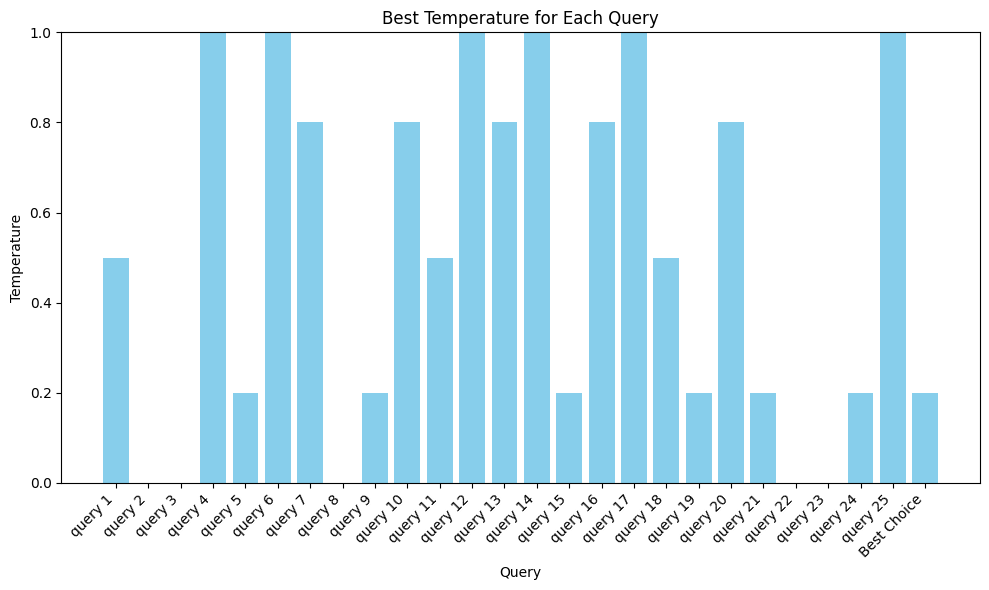

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt

def generate_response(query: str, docs: list[str], temperature: float):
    system_message = (
        "You are a helpful assistant that answers questions about AI using the "
        "context provided below.\n\n"
        "CONTEXT:\n"
        "\n---\n".join(docs)
    )
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": query}
    ]
    # Generate response
    chat_response = groq_client.chat.completions.create(
        model="llama3-70b-8192",
        messages=messages,
        temperature=temperature
    )
    return chat_response.choices[0].message.content

def score_sentence(sentence, model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss
    return torch.exp(loss).item()

def find_best_response(query, docs):
    temperatures = [0.0, 0.2, 0.5, 0.8, 1.0]
    responses = {temp: generate_response(query, docs, temp) for temp in temperatures}

    # Load a pre-trained model for semantic similarity
    sim_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

    # Generate embeddings for the question and candidate answers
    question_embedding = sim_model.encode(query, convert_to_tensor=True)
    answer_embeddings = sim_model.encode(list(responses.values()), convert_to_tensor=True)

    # Calculate semantic similarity
    similarities = [util.pytorch_cos_sim(question_embedding, answer_embedding).item() for answer_embedding in answer_embeddings]

    # Load pre-trained model and tokenizer for fluency scoring
    fluency_model = GPT2LMHeadModel.from_pretrained('gpt2')
    fluency_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Score each candidate answer
    fluency_scores = [score_sentence(answer, fluency_model, fluency_tokenizer) for answer in responses.values()]

    # Normalize the scores
    fluency_scores = 1 / torch.tensor(fluency_scores)  # Convert perplexity to a more intuitive score

    # Combine the scores (weights can be adjusted based on importance)
    combined_scores = torch.tensor(similarities) + fluency_scores

    # Get the index of the highest scoring answer
    best_answer_idx = torch.argmax(combined_scores).item()

    # Get the temperature of the best answer
    best_temperature = temperatures[best_answer_idx]

    return best_temperature, responses

queries = [
    "can you tell me about the Llama LLMs?",
    "can Generative AI models be influenced by emotional stimuli?",
    "Tell me about the Mixtral of experts paper?",
    "what is LLaVa-13b?",
    "Give details about dramatic improvement of the selective SSM when the state size ð is increased?",
    "What are the main differences between supervised and unsupervised learning?",
        "How does reinforcement learning work?",
        "What is the significance of transfer learning in AI?",
        "How do convolutional neural networks (CNNs) function?",
        "What are the key challenges in natural language processing (NLP)?",
        "Can you explain the concept of overfitting in machine learning?",
        "What are generative adversarial networks (GANs) and how do they work?",
        "How do transformers differ from traditional neural networks?",
        "What are the ethical considerations in AI development?",
        "How is explainable AI important in modern applications?",
        "What is the role of big data in machine learning?",
        "How do you evaluate the performance of a machine learning model?",
        "What is the difference between AI, machine learning, and deep learning?",
        "How do recurrent neural networks (RNNs) handle sequential data?",
        "What are the applications of AI in healthcare?",
        "How does AI impact the job market?",
        "What are the limitations of current AI technologies?",
        "How is AI used in autonomous vehicles?",
        "What are the future trends in AI research?",
        "How do you handle missing data in machine learning?"
]

results = []

for idx, query in enumerate(queries, start=1):
    docs = get_docs(query, top_k=5)
    best_temperature, responses = find_best_response(query, docs)
    results.append({
        "query_number": f"query {idx}",
        "query": query,
        "temperature_0.0": responses[0.0],
        "temperature_0.2": responses[0.2],
        "temperature_0.5": responses[0.5],
        "temperature_0.8": responses[0.8],
        "temperature_1.0": responses[1.0],
        "best_temperature": best_temperature
    })

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Determine the most frequently chosen temperature
most_common_temp = df['best_temperature'].mode()[0]

# Append the summary row
summary_row = pd.DataFrame([{
    "query_number": "Best Choice",
    "query": "",
    "temperature_0.0": "",
    "temperature_0.2": "",
    "temperature_0.5": "",
    "temperature_0.8": "",
    "temperature_1.0": "",
    "best_temperature": most_common_temp
}])
df = pd.concat([df, summary_row], ignore_index=True)

# Save the DataFrame to an Excel file
df.to_excel("query_temperature_results.xlsx", index=False)

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(df['query_number'], df['best_temperature'], color='skyblue')
plt.xlabel('Query')
plt.ylabel('Temperature')
plt.title('Best Temperature for Each Query')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.tight_layout()

# Save the plot as an image file
plt.savefig("temperature_results.png")

# Show the plot
plt.show()


# *max_tokens*

Limits the maximum length of the generated response.

*Eg: max_tokens=1500. --> The response will contain no more than 1500 tokens (which include words, punctuation marks, and other textual elements).*

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

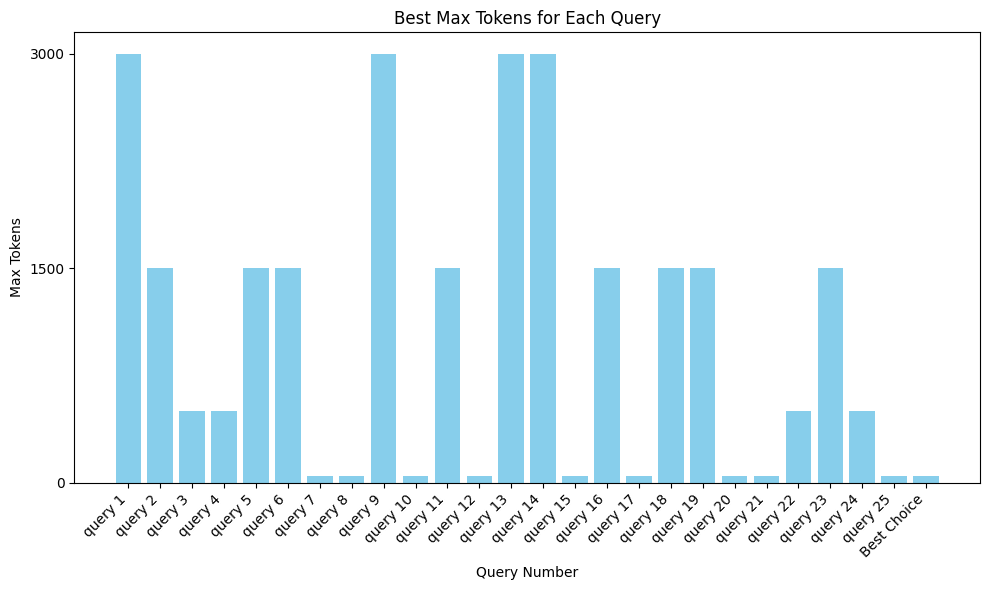

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt

def generate_response(query: str, docs: list[str], max_tokens: int):
    system_message = (
        "You are a helpful assistant that answers questions about AI using the "
        "context provided below.\n\n"
        "CONTEXT:\n"
        "\n---\n".join(docs)
    )
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": query}
    ]
    # Generate response
    chat_response = groq_client.chat.completions.create(
        model="llama3-70b-8192",
        messages=messages,
        max_tokens=max_tokens
    )
    return chat_response.choices[0].message.content

def score_sentence(sentence, model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss
    return torch.exp(loss).item()

def find_best_response(query, docs):
    max_tokens_values = [50, 500, 1500, 3000]
    responses = {tokens: generate_response(query, docs, tokens) for tokens in max_tokens_values}

    # Load a pre-trained model for semantic similarity
    sim_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

    # Generate embeddings for the question and candidate answers
    question_embedding = sim_model.encode(query, convert_to_tensor=True)
    answer_embeddings = sim_model.encode(list(responses.values()), convert_to_tensor=True)

    # Calculate semantic similarity
    similarities = [util.pytorch_cos_sim(question_embedding, answer_embedding).item() for answer_embedding in answer_embeddings]

    # Load pre-trained model and tokenizer for fluency scoring
    fluency_model = GPT2LMHeadModel.from_pretrained('gpt2')
    fluency_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Score each candidate answer
    fluency_scores = [score_sentence(answer, fluency_model, fluency_tokenizer) for answer in responses.values()]

    # Normalize the scores
    fluency_scores = 1 / torch.tensor(fluency_scores)  # Convert perplexity to a more intuitive score

    # Combine the scores (weights can be adjusted based on importance)
    combined_scores = torch.tensor(similarities) + fluency_scores

    # Get the index of the highest scoring answer
    best_answer_idx = torch.argmax(combined_scores).item()

    # Get the max_tokens of the best answer
    best_max_tokens = max_tokens_values[best_answer_idx]

    return best_max_tokens, responses

queries = [
    "can you tell me about the Llama LLMs?",
    "can Generative AI models be influenced by emotional stimuli?",
    "Tell me about the Mixtral of experts paper?",
    "what is LLaVa-13b?",
    "Give details about dramatic improvement of the selective SSM when the state size ð is increased?",
    "What are the main differences between supervised and unsupervised learning?",
    "How does reinforcement learning work?",
    "What is the significance of transfer learning in AI?",
    "How do convolutional neural networks (CNNs) function?",
    "What are the key challenges in natural language processing (NLP)?",
    "Can you explain the concept of overfitting in machine learning?",
    "What are generative adversarial networks (GANs) and how do they work?",
    "How do transformers differ from traditional neural networks?",
    "What are the ethical considerations in AI development?",
    "How is explainable AI important in modern applications?",
    "What is the role of big data in machine learning?",
    "How do you evaluate the performance of a machine learning model?",
    "What is the difference between AI, machine learning, and deep learning?",
    "How do recurrent neural networks (RNNs) handle sequential data?",
    "What are the applications of AI in healthcare?",
    "How does AI impact the job market?",
    "What are the limitations of current AI technologies?",
    "How is AI used in autonomous vehicles?",
    "What are the future trends in AI research?",
    "How do you handle missing data in machine learning?"
]

results = []

for i, query in enumerate(queries, start=1):
    docs = get_docs(query, top_k=5)
    best_max_tokens, responses = find_best_response(query, docs)
    results.append({
        "query_number": f"query {i}",
        "query": query,
        "max_tokens_50": responses[50],
        "max_tokens_500": responses[500],
        "max_tokens_1500": responses[1500],
        "max_tokens_3000": responses[3000],
        "best_max_tokens": best_max_tokens
    })

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Determine the most frequently chosen max_tokens
most_common_tokens = df['best_max_tokens'].mode()[0]

# Append the summary row
summary_row = pd.DataFrame([{
    "query_number": "Best Choice",
    "query": "",
    "max_tokens_50": "",
    "max_tokens_500": "",
    "max_tokens_1500": "",
    "max_tokens_3000": "",
    "best_max_tokens": most_common_tokens
}])
df = pd.concat([df, summary_row], ignore_index=True)

# Save the DataFrame to an Excel file
df.to_excel("query_max_tokens_results.xlsx", index=False)

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(df['query_number'], df['best_max_tokens'], color='skyblue')
plt.xlabel('Query Number')
plt.ylabel('Max Tokens')
plt.title('Best Max Tokens for Each Query')
plt.xticks(rotation=45, ha='right')
plt.yticks([0, 1500, 3000])
plt.tight_layout()

# Save the plot as an image file
plt.savefig("max_tokens_results.png")

# Show the plot
plt.show()


# *top_p*

This is a nucleus sampling parameter. It limits the diversity of the generated text by only considering the top p probability mass (cumulative probability distribution). Lower values mean that the model will consider fewer possible words, making the output more focused.

*Eg: top_p=0.1 --> A value of 0.1 is quite restrictive, ensuring the generated text is of high confidence.*

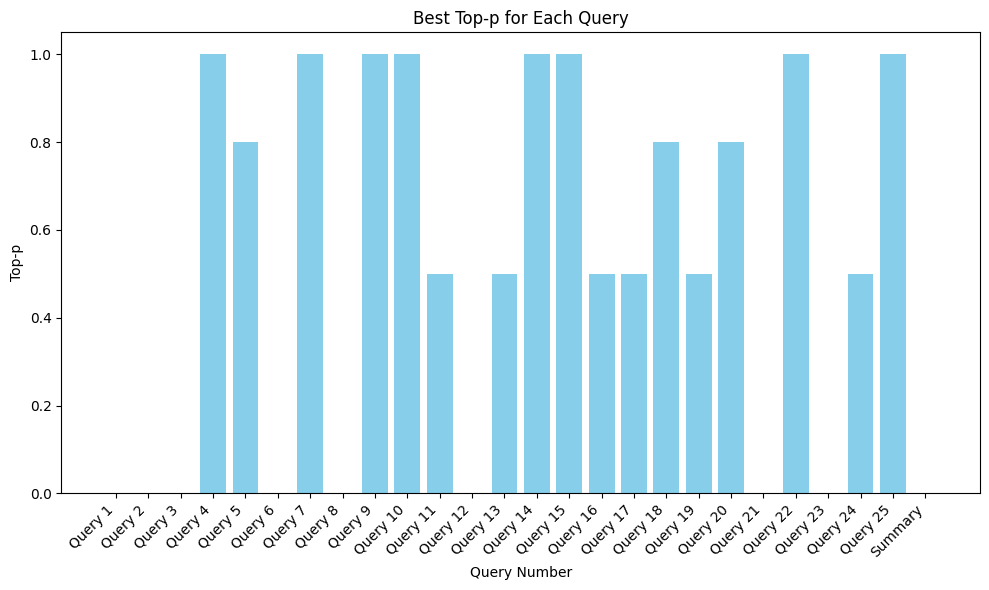

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt

def generate_response(query: str, docs: list[str], top_p: float):
    system_message = (
        "You are a helpful assistant that answers questions about AI using the "
        "context provided below.\n\n"
        "CONTEXT:\n"
        "\n---\n".join(docs)
    )
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": query}
    ]
    # Generate response
    chat_response = groq_client.chat.completions.create(
        model="llama3-70b-8192",
        messages=messages,
        top_p=top_p
    )
    return chat_response.choices[0].message.content

def score_sentence(sentence, model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss
    return torch.exp(loss).item()

def find_best_response(query, docs):
    top_p_values = [0.0, 0.2, 0.5, 0.8, 1.0]
    responses = {p: generate_response(query, docs, p) for p in top_p_values}

    # Load a pre-trained model for semantic similarity
    sim_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

    # Generate embeddings for the question and candidate answers
    question_embedding = sim_model.encode(query, convert_to_tensor=True)
    answer_embeddings = sim_model.encode(list(responses.values()), convert_to_tensor=True)

    # Calculate semantic similarity
    similarities = [util.pytorch_cos_sim(question_embedding, answer_embedding).item() for answer_embedding in answer_embeddings]

    # Load pre-trained model and tokenizer for fluency scoring
    fluency_model = GPT2LMHeadModel.from_pretrained('gpt2')
    fluency_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Score each candidate answer
    fluency_scores = [score_sentence(answer, fluency_model, fluency_tokenizer) for answer in responses.values()]

    # Normalize the scores
    fluency_scores = 1 / torch.tensor(fluency_scores)  # Convert perplexity to a more intuitive score

    # Combine the scores (weights can be adjusted based on importance)
    combined_scores = torch.tensor(similarities) + fluency_scores

    # Get the index of the highest scoring answer
    best_answer_idx = torch.argmax(combined_scores).item()

    # Get the top_p of the best answer
    best_top_p = top_p_values[best_answer_idx]

    return best_top_p, responses

queries = [
    "can you tell me about the Llama LLMs?",
    "can Generative AI models be influenced by emotional stimuli?",
    "Tell me about the Mixtral of experts paper?",
    "what is LLaVa-13b?",
    "Give details about dramatic improvement of the selective SSM when the state size ð is increased?",
    "What are the main differences between supervised and unsupervised learning?",
    "How does reinforcement learning work?",
    "What is the significance of transfer learning in AI?",
    "How do convolutional neural networks (CNNs) function?",
    "What are the key challenges in natural language processing (NLP)?",
    "Can you explain the concept of overfitting in machine learning?",
    "What are generative adversarial networks (GANs) and how do they work?",
    "How do transformers differ from traditional neural networks?",
    "What are the ethical considerations in AI development?",
    "How is explainable AI important in modern applications?",
    "What is the role of big data in machine learning?",
    "How do you evaluate the performance of a machine learning model?",
    "What is the difference between AI, machine learning, and deep learning?",
    "How do recurrent neural networks (RNNs) handle sequential data?",
    "What are the applications of AI in healthcare?",
    "How does AI impact the job market?",
    "What are the limitations of current AI technologies?",
    "How is AI used in autonomous vehicles?",
    "What are the future trends in AI research?",
    "How do you handle missing data in machine learning?"
]

results = []

for i, query in enumerate(queries):
    docs = get_docs(query, top_k=5)
    best_top_p, responses = find_best_response(query, docs)
    results.append({
        "query_number": f"Query {i + 1}",
        "query": query,
        "top_p_0.0": responses[0.0],
        "top_p_0.2": responses[0.2],
        "top_p_0.5": responses[0.5],
        "top_p_0.8": responses[0.8],
        "top_p_1.0": responses[1.0],
        "best_top_p": best_top_p
    })

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Determine the most frequently chosen top_p
most_common_top_p = df['best_top_p'].mode()[0]

# Append the summary row
summary_row = pd.DataFrame([{"query_number": "Summary", "query": "Best Choice", "top_p_0.0": "", "top_p_0.2": "", "top_p_0.5": "", "top_p_0.8": "", "top_p_1.0": "", "best_top_p": most_common_top_p}])
df = pd.concat([df, summary_row], ignore_index=True)

# Save the DataFrame to an Excel file
df.to_excel("query_top_p_results.xlsx", index=False)

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(df['query_number'], df['best_top_p'], color='skyblue')
plt.xlabel('Query Number')
plt.ylabel('Top-p')
plt.title('Best Top-p for Each Query')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot as an image file
plt.savefig("top_p_results.png")

# Show the plot
plt.show()


# *frequency_penalty*

Penalizes repeated phrases in the generated response.

*Eg: frequency_penalty=0.1 --> A small positive value (like 0.1) will slightly discourage the model from repeating words or phrases it has already used, promoting more varied responses.*

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

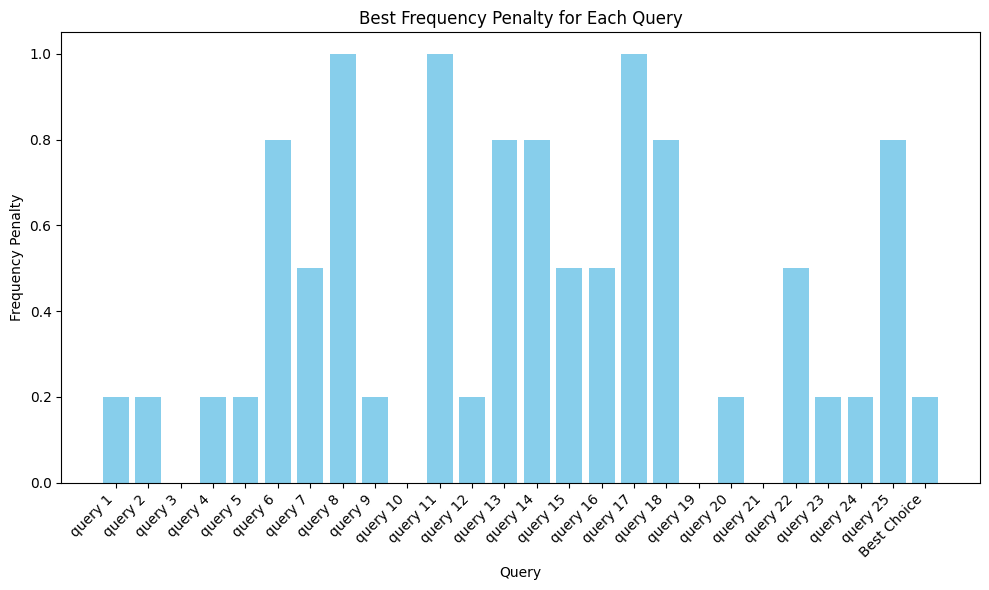

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt

def generate_response(query: str, docs: list[str], frequency_penalty: float):
    system_message = (
        "You are a helpful assistant that answers questions about AI using the "
        "context provided below.\n\n"
        "CONTEXT:\n"
        "\n---\n".join(docs)
    )
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": query}
    ]
    # Generate response
    chat_response = groq_client.chat.completions.create(
        model="llama3-70b-8192",
        messages=messages,
        frequency_penalty=frequency_penalty
    )
    return chat_response.choices[0].message.content

def score_sentence(sentence, model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss
    return torch.exp(loss).item()

def find_best_response(query, docs):
    frequency_penalties = [0.0, 0.2, 0.5, 0.8, 1.0]
    responses = {penalty: generate_response(query, docs, penalty) for penalty in frequency_penalties}

    # Load a pre-trained model for semantic similarity
    sim_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

    # Generate embeddings for the question and candidate answers
    question_embedding = sim_model.encode(query, convert_to_tensor=True)
    answer_embeddings = sim_model.encode(list(responses.values()), convert_to_tensor=True)

    # Calculate semantic similarity
    similarities = [util.pytorch_cos_sim(question_embedding, answer_embedding).item() for answer_embedding in answer_embeddings]

    # Load pre-trained model and tokenizer for fluency scoring
    fluency_model = GPT2LMHeadModel.from_pretrained('gpt2')
    fluency_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Score each candidate answer
    fluency_scores = [score_sentence(answer, fluency_model, fluency_tokenizer) for answer in responses.values()]

    # Normalize the scores
    fluency_scores = 1 / torch.tensor(fluency_scores)  # Convert perplexity to a more intuitive score

    # Combine the scores (weights can be adjusted based on importance)
    combined_scores = torch.tensor(similarities) + fluency_scores

    # Get the index of the highest scoring answer
    best_answer_idx = torch.argmax(combined_scores).item()

    # Get the frequency penalty of the best answer
    best_frequency_penalty = frequency_penalties[best_answer_idx]

    return best_frequency_penalty, responses

queries = [
    "can you tell me about the Llama LLMs?",
    "can Generative AI models be influenced by emotional stimuli?",
    "Tell me about the Mixtral of experts paper?",
    "what is LLaVa-13b?",
    "Give details about dramatic improvement of the selective SSM when the state size ð is increased?",
    "What are the main differences between supervised and unsupervised learning?",
    "How does reinforcement learning work?",
    "What is the significance of transfer learning in AI?",
    "How do convolutional neural networks (CNNs) function?",
    "What are the key challenges in natural language processing (NLP)?",
    "Can you explain the concept of overfitting in machine learning?",
    "What are generative adversarial networks (GANs) and how do they work?",
    "How do transformers differ from traditional neural networks?",
    "What are the ethical considerations in AI development?",
    "How is explainable AI important in modern applications?",
    "What is the role of big data in machine learning?",
    "How do you evaluate the performance of a machine learning model?",
    "What is the difference between AI, machine learning, and deep learning?",
    "How do recurrent neural networks (RNNs) handle sequential data?",
    "What are the applications of AI in healthcare?",
    "How does AI impact the job market?",
    "What are the limitations of current AI technologies?",
    "How is AI used in autonomous vehicles?",
    "What are the future trends in AI research?",
    "How do you handle missing data in machine learning?"
]

results = []

for i, query in enumerate(queries, start=1):
    docs = get_docs(query, top_k=5)
    best_frequency_penalty, responses = find_best_response(query, docs)
    results.append({
        "query_number": f"query {i}",
        "query": query,
        "frequency_penalty_0.0": responses[0.0],
        "frequency_penalty_0.2": responses[0.2],
        "frequency_penalty_0.5": responses[0.5],
        "frequency_penalty_0.8": responses[0.8],
        "frequency_penalty_1.0": responses[1.0],
        "best_frequency_penalty": best_frequency_penalty
    })

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Determine the most frequently chosen frequency penalty
most_common_penalty = df['best_frequency_penalty'].mode()[0]

# Append the summary row
summary_row = pd.DataFrame([{
    "query_number": "Best Choice",
    "query": "Best Choice",
    "frequency_penalty_0.0": "",
    "frequency_penalty_0.2": "",
    "frequency_penalty_0.5": "",
    "frequency_penalty_0.8": "",
    "frequency_penalty_1.0": "",
    "best_frequency_penalty": most_common_penalty
}])
df = pd.concat([df, summary_row], ignore_index=True)

# Save the DataFrame to an Excel file
df.to_excel("query_frequency_penalty_results.xlsx", index=False)

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(df['query_number'], df['best_frequency_penalty'], color='skyblue')
plt.xlabel('Query')
plt.ylabel('Frequency Penalty')
plt.title('Best Frequency Penalty for Each Query')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot as an image file
plt.savefig("frequency_penalty_results.png")

# Show the plot
plt.show()


# *presence_penalty*

Encourages the model to talk about new topics.

*Eg: presence_penalty=0.2 --> A positive value (like 0.2) will push the model to introduce new concepts or subjects rather than sticking to what has already been discussed, promoting novelty in the response.*

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

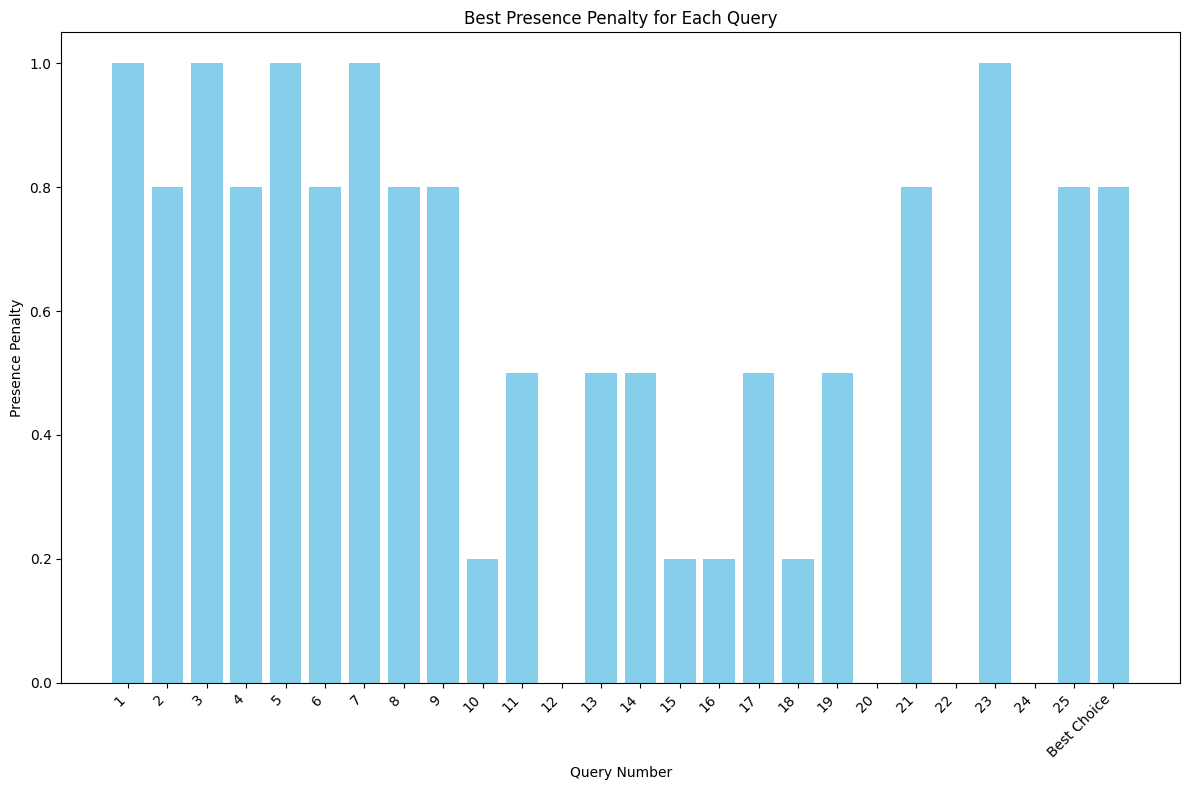

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt

def generate_response(query: str, docs: list[str], presence_penalty: float):
    system_message = (
        "You are a helpful assistant that answers questions about AI using the "
        "context provided below.\n\n"
        "CONTEXT:\n"
        "\n---\n".join(docs)
    )
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": query}
    ]
    # Generate response
    chat_response = groq_client.chat.completions.create(
        model="llama3-70b-8192",
        messages=messages,
        presence_penalty=presence_penalty
    )
    return chat_response.choices[0].message.content

def score_sentence(sentence, model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss
    return torch.exp(loss).item()

def find_best_response(query, docs):
    presence_penalties = [0.0, 0.2, 0.5, 0.8, 1.0]
    responses = {penalty: generate_response(query, docs, penalty) for penalty in presence_penalties}

    # Load a pre-trained model for semantic similarity
    sim_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

    # Generate embeddings for the question and candidate answers
    question_embedding = sim_model.encode(query, convert_to_tensor=True)
    answer_embeddings = sim_model.encode(list(responses.values()), convert_to_tensor=True)

    # Calculate semantic similarity
    similarities = [util.pytorch_cos_sim(question_embedding, answer_embedding).item() for answer_embedding in answer_embeddings]

    # Load pre-trained model and tokenizer for fluency scoring
    fluency_model = GPT2LMHeadModel.from_pretrained('gpt2')
    fluency_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Score each candidate answer
    fluency_scores = [score_sentence(answer, fluency_model, fluency_tokenizer) for answer in responses.values()]

    # Normalize the scores
    fluency_scores = 1 / torch.tensor(fluency_scores)  # Convert perplexity to a more intuitive score

    # Combine the scores (weights can be adjusted based on importance)
    combined_scores = torch.tensor(similarities) + fluency_scores

    # Get the index of the highest scoring answer
    best_answer_idx = torch.argmax(combined_scores).item()

    # Get the presence penalty of the best answer
    best_presence_penalty = presence_penalties[best_answer_idx]

    return best_presence_penalty, responses

queries = [
    "can you tell me about the Llama LLMs?",
    "can Generative AI models be influenced by emotional stimuli?",
    "Tell me about the Mixtral of experts paper?",
    "what is LLaVa-13b?",
    "Give details about dramatic improvement of the selective SSM when the state size ð is increased?",
    "What are the main differences between supervised and unsupervised learning?",
    "How does reinforcement learning work?",
    "What is the significance of transfer learning in AI?",
    "How do convolutional neural networks (CNNs) function?",
    "What are the key challenges in natural language processing (NLP)?",
    "Can you explain the concept of overfitting in machine learning?",
    "What are generative adversarial networks (GANs) and how do they work?",
    "How do transformers differ from traditional neural networks?",
    "What are the ethical considerations in AI development?",
    "How is explainable AI important in modern applications?",
    "What is the role of big data in machine learning?",
    "How do you evaluate the performance of a machine learning model?",
    "What is the difference between AI, machine learning, and deep learning?",
    "How do recurrent neural networks (RNNs) handle sequential data?",
    "What are the applications of AI in healthcare?",
    "How does AI impact the job market?",
    "What are the limitations of current AI technologies?",
    "How is AI used in autonomous vehicles?",
    "What are the future trends in AI research?",
    "How do you handle missing data in machine learning?"
]

results = []

for idx, query in enumerate(queries, start=1):
    docs = get_docs(query, top_k=5)
    best_presence_penalty, responses = find_best_response(query, docs)
    results.append({
        "query_number": idx,
        "query": query,
        "presence_penalty_0.0": responses[0.0],
        "presence_penalty_0.2": responses[0.2],
        "presence_penalty_0.5": responses[0.5],
        "presence_penalty_0.8": responses[0.8],
        "presence_penalty_1.0": responses[1.0],
        "best_presence_penalty": best_presence_penalty
    })

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Determine the most frequently chosen presence penalty
most_common_penalty = df['best_presence_penalty'].mode()[0]

# Append the summary row
summary_row = pd.DataFrame([{"query_number": "Best Choice", "query": "", "presence_penalty_0.0": "", "presence_penalty_0.2": "", "presence_penalty_0.5": "", "presence_penalty_0.8": "", "presence_penalty_1.0": "", "best_presence_penalty": most_common_penalty}])
df = pd.concat([df, summary_row], ignore_index=True)

# Save the DataFrame to an Excel file
df.to_excel("query_presence_penalty_results.xlsx", index=False)

# Plot the results
plt.figure(figsize=(12, 8))
plt.bar(df['query_number'].astype(str), df['best_presence_penalty'], color='skyblue')
plt.xlabel('Query Number')
plt.ylabel('Presence Penalty')
plt.title('Best Presence Penalty for Each Query')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot as an image file
plt.savefig("presence_penalty_results.png")

# Show the plot
plt.show()
